#Pull Data

In [76]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-08-15 16:27:41--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2019-08-15 16:27:42 (302 KB/s) - ‘loan_train.csv’ saved [23101/23101]



In [77]:
import numpy as np 
import pandas as pd
import seaborn as sns; import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [78]:
data = pd.read_csv("loan_train.csv")

In [79]:
col_names = ['loan_status','Principal','terms','effective_date','due_date','age','education','Gender']

In [80]:
df = data[col_names]

In [81]:
df.head(10)

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male
5,PAIDOFF,1000,30,9/9/2016,10/8/2016,36,college,male
6,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,male
7,PAIDOFF,800,15,9/10/2016,9/24/2016,26,college,male
8,PAIDOFF,300,7,9/10/2016,9/16/2016,29,college,male
9,PAIDOFF,1000,15,9/10/2016,10/9/2016,39,High School or Below,male


In [82]:
from pandas.api.types import is_numeric_dtype

#Even though it is clear we investigate the data set and find out that there are non numeric entries

In [83]:
is_numeric_dtype(df['loan_status'])

False

In [84]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [85]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

#Visualize the data as histogram using the variables GENDER, AGE, LOAN STATUS

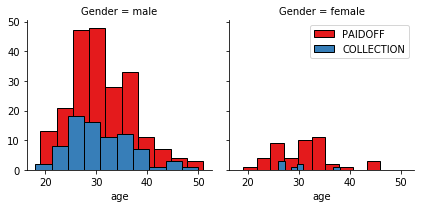

In [86]:
a = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
a.map(plt.hist, 'age', ec="k")
a.axes[-1].legend()
plt.show()

#The existing data for males seems to be way greater or we could assume that males engage in debt more regularely

In [87]:
df['Gender'].value_counts()

male      294
female     52
Name: Gender, dtype: int64

In [88]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

#the normalized data suggests that females are less risky (repayment) clients

In [89]:
df['education'].value_counts()

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

#the n of "Master or Above" is insignificantly small within our variable "education" so that we may neglect the two entires

In [90]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [91]:
df = df[df.education != 'Master or Above']

#we change categorical variables to dummies/binary entries

In [92]:
categor = pd.get_dummies(df['education'])
cols = ['loan_status','Principal','terms','effective_date',
             'due_date','age','Gender']

In [93]:
df_processed = df[cols]; df_processed = pd.concat([df_processed,categor],axis=1)
df_processed['Gender'] = df_processed['Gender'].replace(to_replace = 
            ['male','female'], value = [0,1])

In [94]:
df_processed['due_date'] = pd.to_numeric(df_processed['due_date'], errors='coerce')
df_processed['effective_date'] = pd.to_numeric(df_processed['effective_date'], 
            errors='coerce')

In [95]:
x = np.array(df_processed); x = x[:,1:8]
y = df['loan_status'].replace(to_replace = ['PAIDOFF','COLLECTION'], value=[0,1]).values

#We normalize and split our data into training and testing set applying the ratio 0.8/0.2

In [96]:
x = preprocessing.StandardScaler().fit(x).transform(x.astype(float))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (275, 7) (275,)
Test set: (69, 7) (69,)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#k-Nearest Neighbour

[0.71014493 0.76811594 0.69565217 0.75362319 0.71014493 0.79710145
 0.7826087  0.8115942  0.72463768 0.75362319]


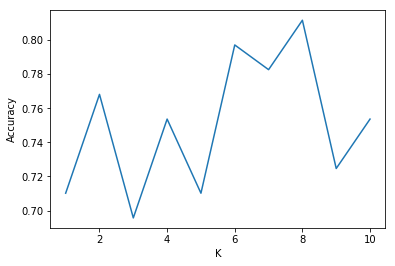

Best K: 8


In [97]:
K = 11
mean_acc = np.zeros((K-1))
std_acc = np.zeros((K-1))

for n in range(1,K):
    
    neigh = KNeighborsClassifier(n_neighbors = n).fit(x_train, y_train)
    y_hat = neigh.predict(x_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_hat)

    std_acc[n-1] = np.std(y_hat == y_test) / np.sqrt(y_hat.shape[0])

print(mean_acc)

plt.plot(range(1, 11), mean_acc)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

best_K = np.argmax(mean_acc) + 1

print("Best K:", best_K)

best_knn = KNeighborsClassifier(n_neighbors = best_K).fit(x_train, y_train)
y_pred_knn = best_knn.predict(x_test)

#We Evaluate our model(s) using Jaccard index, F1-score, Log Loss

In [98]:
#Create an Empty Dictionary for Model Evaluation Scores
test_scores = {}
test_scores['KNN-jaccard'] = jaccard_similarity_score(y_test, y_pred_knn)
test_scores['KNN-f1-score']=f1_score(y_test, y_pred_knn, average = 'weighted')

In [99]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(x_train, y_train)

y_pred = clf_tree.predict(x_test)

test_scores['Tree-jaccard'] = jaccard_similarity_score(y_test, y_pred)
test_scores['Tree-f1-score'] = f1_score(y_test, y_pred, average = 'weighted')

In [100]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(C=0.01, solver='liblinear').fit(x_train, y_train)

y_hat_LR = LR.predict(x_test)
y_hat_prob = LR.predict_proba(x_test)

test_scores['LogReg-jaccard'] = jaccard_similarity_score(y_test, y_hat_LR)
test_scores['LogReg-f1-score'] = f1_score(y_test, y_hat_LR, average = 'weighted')
#since we can calculate a probability, log loss comes into play
test_scores['LogReg-LogLoss'] = log_loss(y_test, y_hat_prob)

In [101]:
from sklearn import svm

clf = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train) 
y_pred_svm = clf.predict(x_test)

test_scores['SVM-jaccard'] = jaccard_similarity_score(y_test, y_pred_svm)
test_scores['SVM-f1-score'] = f1_score(y_test, y_pred_svm, average = 'weighted')

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


#We summarize our model where Logistic Regressions seems to be the most favourable with test scores closest to the most desirable value 1 (we can not compare log loss)

In [102]:
score_evaluation = pd.DataFrame.from_dict(test_scores, orient = 'index')
print(score_evaluation)

                        0
KNN-jaccard      0.811594
KNN-f1-score     0.759203
Tree-jaccard     0.753623
Tree-f1-score    0.756741
LogReg-jaccard   0.826087
LogReg-f1-score  0.797200
LogReg-LogLoss   0.568488
SVM-jaccard      0.797101
SVM-f1-score     0.730993
